# Preprocessing

In [78]:
import sys
import asyncio

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

# Read the CSV file
original_df = pd.read_csv('used_cars.csv')


def preprocessing(df):
    df = df.copy()
    # Per non avere valori nulli nella colonna Service History
    df['Service history'] = df['Service history'].fillna("Unavailable")
    df['Service history'] = df['Service history'].map({'Full': True, 'Unavailable': False})
    # Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
    # In python gli alberi di decisione non supportano feature categoriche

    # Prendere solo la marca dell'auto
    df['title'] = df['title'].apply(lambda x: x.split()[0] if isinstance(x, str) else x)

    # Abbiamo provato a togliere proprio title ma predizioni peggiori

    # Eliminare la prima colonna che è l'indice
    df = df.drop(df.columns[0], axis=1)

    # Prendi la cilindrata dell'auto e trasformala in un numero
    df['Engine'] = df['Engine'].str.replace('L', '').astype(float)

    df['Gearbox'] = df['Gearbox'].map({'Automatic': True, 'Manual': False})
    df = df.rename(columns={'Gearbox': 'Gearbox Automatic'})

    df['Emission Class'] = pd.to_numeric(df['Emission Class'].str.replace('Euro ', ''), errors='coerce')

    df['Previous Owners'] = df['Previous Owners'].fillna(0)

    df = df[~df['Body type'].isin(["Combi Van", "Minibus", "Pickup"])]

    df['Fuel type'] = df['Fuel type'].apply(lambda x: {'Petrol Plug-in Hybrid': "Electric/Hybrid", 'Petrol Hybrid': "Electric/Hybrid", 'Diesel Hybrid': "Electric/Hybrid", "Electric": "Electric/Hybrid"}.get(x, x))

    df["Doors"] = df["Doors"].fillna(5)
    df["Seats"] = df["Seats"].fillna(5)

    value_counts = df["title"].value_counts()

    # Filter the values that occur 10 times or more
    values_to_keep = value_counts[value_counts >= 20].index

    # Filter the DataFrame to keep only rows with the desired values
    df = df[df["title"].isin(values_to_keep)]
    
    # drop title
    df = df.drop(columns=["title"])

    df = pd.get_dummies(df, columns=['Fuel type', 'Body type', 
                                     # 'title'
                                     ])
    df.to_csv('preprocessed_data.csv', index=False)

    # Algoritmi necessitano di valori non nulli
    df = df.dropna()

    return df


preprocessed_df = preprocessing(original_df)
target_column = "Price"
# Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
# In python gli alberi di decisione non supportano feature categoriche


print(preprocessed_df)

X = preprocessed_df.drop(target_column, axis=1)
y = preprocessed_df[target_column]

# y_extracted = preprocessed_df[[target_column]]
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y_extracted).ravel()


...

      Price  Mileage(miles)  Registration_Year  Previous Owners  Engine  \
0      6900           70189               2016              3.0     1.4   
1      1495           88585               2008              4.0     1.2   
2       949          137000               2011              0.0     1.4   
3      2395           96731               2010              5.0     1.4   
4      1000           85000               2013              0.0     1.3   
...     ...             ...                ...              ...     ...   
3680   1395           76202               2006              4.0     1.6   
3681   6990          119000               2012              0.0     2.0   
3682   3995          139000               2013              0.0     2.0   
3683   1390          179190               2007              0.0     2.2   
3684   2000           82160               2013              7.0     1.2   

      Gearbox Automatic  Doors  Seats  Emission Class  Service history  \
0                 False  

Ellipsis

# Processing dataset 2

In [ ]:
import sys
import asyncio

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

# Dataset da https://data.world/data-society/used-cars-data
original_df = pd.read_csv('autos.csv')


def preprocessing(df):
    df = df.copy()
    
    # Drop colonne inutili
    df = df.drop(columns=['dateCrawled', 'dateCreated', 'nrOfPictures', 'lastSeen', 'postalCode', 'seller', 'offerType', 'abtest', 'monthOfRegistration'])
    
    # Drop nome e model in quanto creerebbero troppe colonne con il one-hot encoding, inoltre esiste la colonna brand
    df = df.drop(columns=['name', 'model'])
    
    # gearbox in boolen e rinominazione
    df['gearbox'] = df['gearbox'].map({'manuell': False, 'automatik': True})
    df = df.rename(columns={'gearbox': 'gearboxAutomatic'})
    
    # notRepairedDamage in boolean
    df['notRepairedDamage'] = df['notRepairedDamage'].map({'ja': True, 'nein': False})
    
    df = df.rename(columns={"powerPS": "powerHP"})
    
    # mantieni solo brand che hanno più dell'1.5% delle voci
    value_counts = df["brand"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.015 * len(df)].index
    df = df[df["brand"].isin(values_to_keep)]


    df['vehicleType'] = df['vehicleType'].replace('andere', 'altro')

    # mantieni solo vehicleType che hanno più dell'3% delle voci
    value_counts = df["vehicleType"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.03 * len(df)].index
    df = df[df["vehicleType"].isin(values_to_keep)]
    
    # mantieni solo fuelType che hanno più dell'1% delle voci
    value_counts = df["fuelType"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.01 * len(df)].index
    df = df[df["fuelType"].isin(values_to_keep)]
    
    # In quanto solo diesel e benzina hanno un numero significativo di voci, rendiamo la colonna booleana
    df['fuelType'] = df['fuelType'].map({'diesel': True, 'benzin': False})
    df = df.rename(columns={'fuelType': 'fuelTypeDiesel'})
    
    # Elimina valori eccessivi nel prezzo
    df = df[df['price'] < 1000000]
    df = df[df['price'] > 100]
    
    

    # Algoritmi necessitano di valori non nulli
    df = df.dropna()
    df.to_csv('preprocessed_data.csv', index=False)

    # Fai one-hot encoding delle colonne categoriche
    df = pd.get_dummies(df, columns=['vehicleType', 'brand'])
    
    # Prendi 10000 voci a caso
    df = df.sample(10000)

    return df


preprocessed_df = preprocessing(original_df)
target_column = "price"

# Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
# In python gli alberi di decisione non supportano feature categoriche


print(preprocessed_df)

X = preprocessed_df.drop(target_column, axis=1)
y = preprocessed_df[target_column]

# y_extracted = preprocessed_df[[target_column]]
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y_extracted).ravel()


...

# Apprendimento supervisionato

In [125]:
def calculate_baseline_score(df, target_column, scoring):
    # Per vedere se la loss del modello è migliore di quella che si potrebbe ottenere con una predizione banale, come media o mediana
    if scoring == "neg_root_mean_squared_error":
        baseline_prediction = df[target_column].mean()
        baseline_error = - (df[target_column] - baseline_prediction).pow(2).mean() ** 0.5
    elif scoring == "neg_mean_absolute_error":
        baseline_prediction = df[target_column].median()
        baseline_error = - (df[target_column] - baseline_prediction).abs().mean()
    else:
        raise ValueError("Invalid scoring metric")

    return baseline_error


def search_hyperparameters(model, param_grid, X, y, cv, scoring):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)

    # scores = cross_val_score(ctf, X, y, cv=cv, scoring=scoring)
    # grid_search.fit implicitamente usa cross_val_score e quindi non abbiamo bisogno di ripeterlo
    # Gli score ottenuti usando cross_val_score con i migliori iperparametri sono già restituiti da grid_search
    scores = grid_search.best_score_
    params = grid_search.best_params_
    print("Scores:", scores)
    print("Best params:", params)

    model_results = {"scores": scores, "params": params, "model": grid_search.best_estimator_}

    return model_results


def performance_comparison(train_results):
    for scoring_metric in train_results:        
        fig, ax = plt.subplots(figsize=(10, 6))

        models = list(train_results[scoring_metric].keys())
        
        if not train_results[scoring_metric][models[0]]:
            continue
        scores = [train_results[scoring_metric][model]["scores"] for model in train_results[scoring_metric]]

        # Extract mean scores for plotting
        mean_scores = [np.mean(score) for score in scores]

        ax.bar(models, mean_scores, color=['blue', 'green', 'red'])
        plt.gca().invert_yaxis()

        ax.set_title(f'Performance Comparison ({scoring_metric})')
        ax.set_xlabel('Models')
        ax.set_ylabel('Mean Score')

        # Adjust y-axis limits to better visualize negative scores
        # ymin = max(mean_scores) * 1.1 if min(mean_scores) < 0 else max(mean_scores) * 0.9
        # ymax = min(mean_scores) * 1.1 if max(mean_scores) > 0 else min(mean_scores) * 0.9
        # ax.set_ylim([ymin, ymax])
        ax.grid(True)

        # Adding text for each bar
        # for i, v in enumerate(mean_scores):
        #     if v < 0:
        #         ax.text(i, v - (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='top')
        #     else:
        #         ax.text(i, v + (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='bottom')

        plt.savefig(f"performance_comparison_{scoring_metric}.png")


def show_learning_curves(search_results, X_set, y_set, cv):
    # Initialize an empty DataFrame
    variance_df = pd.DataFrame(columns=['Model', 'Train Score Variance', 'Test Score Variance'])

    for scoring_metric in search_results:
        for model_name in search_results[scoring_metric]:
            title = f"Learning Curve ({model_name}, {scoring_metric})"
            estimator = search_results[scoring_metric][model_name].get("model", None)
            if estimator is None:
                continue

            plt.figure(figsize=(10, 6))
            plt.title(title)
            plt.xlabel("Training examples")
            plt.ylabel(scoring_metric)

            train_sizes, train_scores, test_scores = learning_curve(
                estimator, X_set, y_set, cv=cv, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10), scoring=scoring_metric
            )

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.grid()

            plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

            plt.legend(loc="best")
            plt.savefig(f"{title}.png")
            print(f"Saved {title}.png")

            # Calculate the variance of the train and test scores
            train_score_variance = np.var(train_scores, axis=1)[-1]
            test_score_variance = np.var(test_scores, axis=1)[-1]

            # Create a DataFrame with a single row of data
            variance_data = pd.DataFrame([{
                'Model': title,
                'Train Score Std dev': train_scores_std[-1],
                'Test Score Std dev': test_scores_std[-1],
                'Train Score Variance': train_score_variance,
                'Test Score Variance': test_score_variance,
                'Ratio': test_score_variance / train_score_variance
            }])

            # Append the new data to the DataFrame
            variance_df = pd.concat([variance_df, variance_data], ignore_index=True)
            print(variance_df.head())

    # Print the DataFrame
    return variance_df


# Scelte due metriche di scoring
scorings = [
    # 'neg_root_mean_squared_error', 
    'neg_mean_absolute_error'
]


## Training dei modelli

In [121]:
results = {s: {"decision_tree": {},
               "random_forest": {},
               "gradient_boosting": {}} for s in scorings}

dtr_param_grid = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    # 'splitter': ['best'],
    # 'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

rfr_param_grid = {
    # 'n_estimators': [100, 200],
    # 'criterion': ["squared_error", "friedman_mse", "poisson"],
    'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

gbr_param_grid = {
    # 'n_estimators': [100, 200],
    # 'loss': ['squared_error', 'huber', 'quantile'],
    'learning_rate': [0.01, 0.1, 0.5],
    # 'criterion': ['friedman_mse', 'squared_error'],
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
    # 'subsample': [0.1, 0.5, 1.0],
}

# Perform 5-fold cross-validation, repeated 3 times, and print the average score
cv = RepeatedKFold(n_splits=5, n_repeats=1)
# TODO fonty per la grid search fa solo cv=5 che come se fosse n_repeats=1

# Addestrare ogni modello per ogni metrica di scoring
for scoring in scorings:
    baseline_score = calculate_baseline_score(original_df, target_column, scoring)
    print(f"Baseline for scoring metric {scoring}: ", baseline_score)

    dtr = DecisionTreeRegressor()
    print(f"Training decision tree with scoring metric {scoring}")
    results[scoring]["decision_tree"] = search_hyperparameters(dtr, dtr_param_grid, X, y, cv, scoring)

    rfr = RandomForestRegressor()
    print(f"Training random forest with scoring metric {scoring}")
    results[scoring]["random_forest"] = search_hyperparameters(rfr, rfr_param_grid, X, y, cv, scoring)

    gbr = GradientBoostingRegressor()
    print(f"Training gradient boosted model with scoring metric {scoring}")
    results[scoring]["gradient_boosting"] = search_hyperparameters(gbr, gbr_param_grid, X, y, cv, scoring)

print(results)


Baseline for scoring metric neg_mean_absolute_error:  -16051.040010443357
Training decision tree with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Scores: -2002.8645000000001
Best params: {'criterion': 'absolute_error'}
Training random forest with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Scores: -1592.6452666903824
Best params: {'max_depth': None}
Training gradient boosted model with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Scores: -1653.860990941037
Best params: {'learning_rate': 0.5}
{'neg_root_mean_squared_error': {'decision_tree': {}, 'random_forest': {}, 'gradient_boosting': {}}, 'neg_mean_absolute_error': {'decision_tree': {'scores': -2002.8645000000001, 'params': {'criterion': 'absolute_error'}, 'model': DecisionTreeRegressor(criterion='absolute_error')}, 'random_forest': {'scores': -1592.6452666903824, 'params'

## Performance Comparison

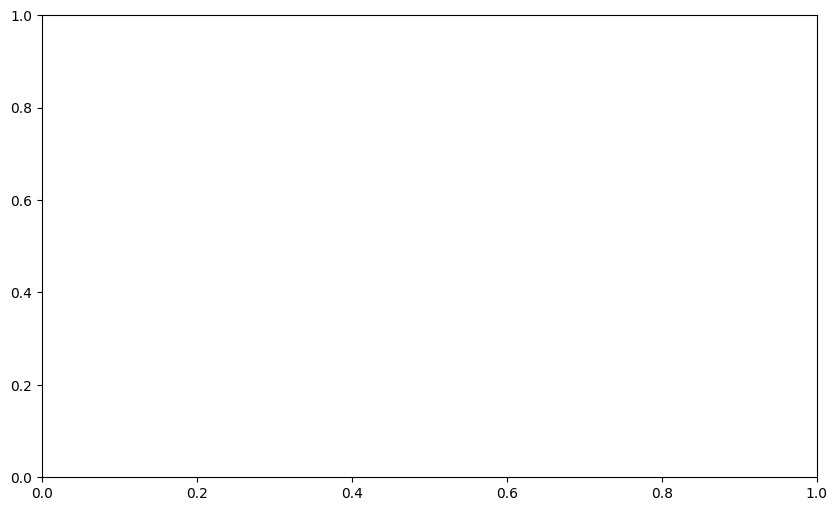

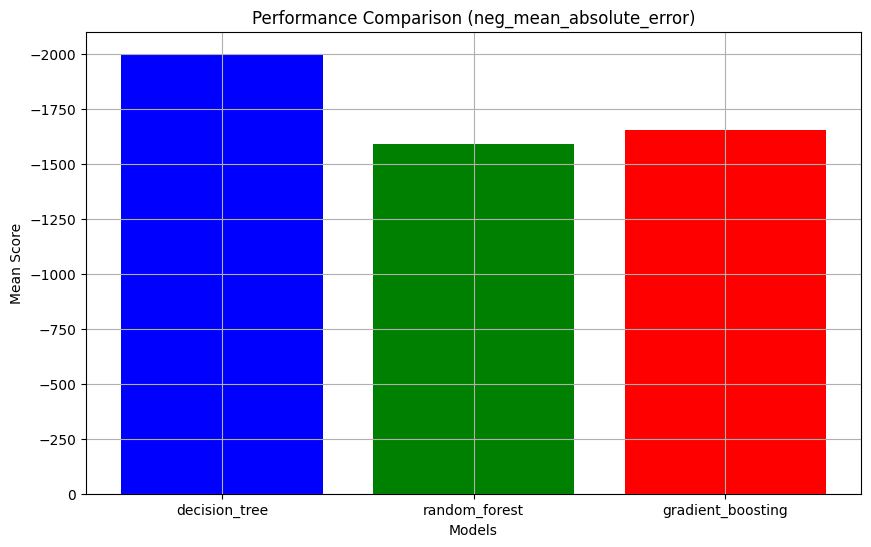

In [122]:
performance_comparison(results)

## Learning Curve

Saved Learning Curve (decision_tree, neg_mean_absolute_error).png
                                                     Model  \
0  Learning Curve (decision_tree, neg_mean_absolute_error)   

   Train Score Variance  Test Score Variance       Ratio  
0             45.710591         21690.194722  474.511358  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_46232\3133450597.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (random_forest, neg_mean_absolute_error).png
                                                     Model  \
0  Learning Curve (decision_tree, neg_mean_absolute_error)   
1  Learning Curve (random_forest, neg_mean_absolute_error)   

   Train Score Variance  Test Score Variance       Ratio  
0             45.710591         21690.194722  474.511358  
1            191.990138          5530.774382   28.807596  
Saved Learning Curve (gradient_boosting, neg_mean_absolute_error).png
                                                         Model  \
0      Learning Curve (decision_tree, neg_mean_absolute_error)   
1      Learning Curve (random_forest, neg_mean_absolute_error)   
2  Learning Curve (gradient_boosting, neg_mean_absolute_error)   

   Train Score Variance  Test Score Variance       Ratio  
0             45.710591         21690.194722  474.511358  
1            191.990138          5530.774382   28.807596  
2            269.293812         11201.039805   41.594122  

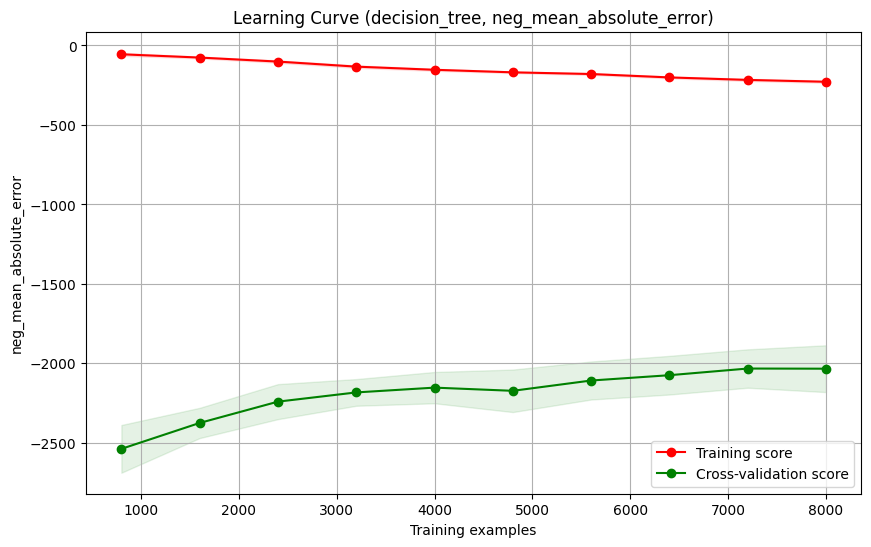

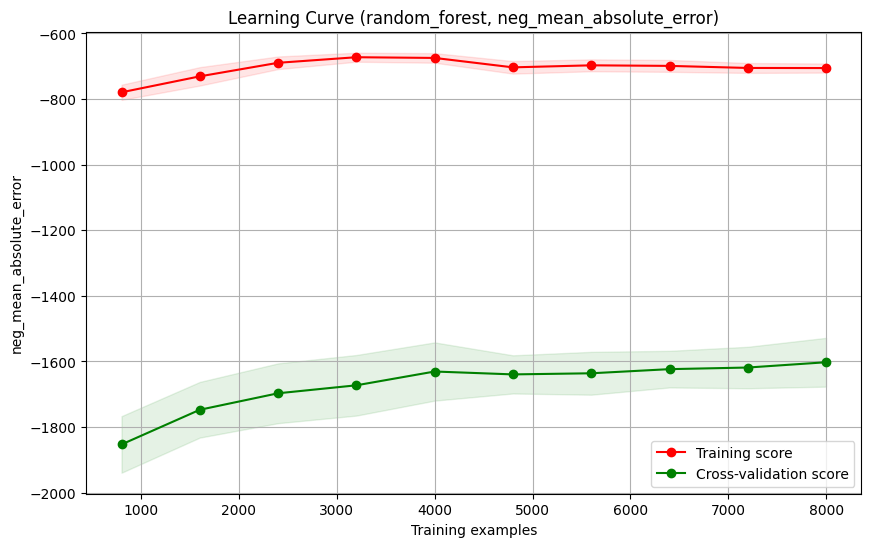

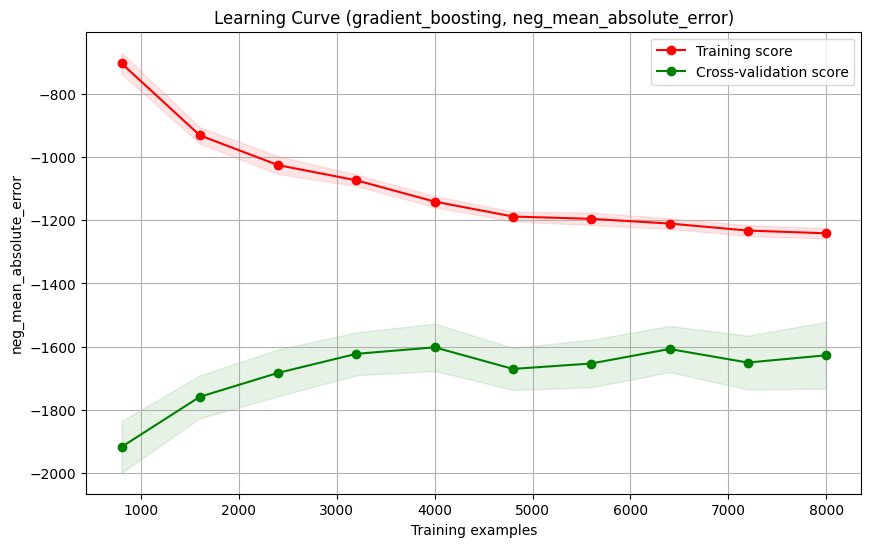

In [123]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
var_df = show_learning_curves(results, X, y, cv)
print(var_df.head())

# Overfitting
Dunque si riprova con regressione lineare, lasso e ridge

In [126]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

results_linear = {s: {"linear_regression": {},
                        "lasso": {},
                        "ridge": {}} for s in scorings}

lr_param_grid = {
    'fit_intercept': [True, False],
}

lasso_param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter': [1000, 10000, 50000],
    'selection': ['cyclic', 'random'],
}

ridge_param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter': [1000, 10000, 50000],
}

cv = RepeatedKFold(n_splits=5, n_repeats=1)

for scoring in scorings[:1]:
    lr = LinearRegression()
    print(f"Training linear regression with scoring metric {scoring}")
    results_linear[scoring]["linear_regression"] = search_hyperparameters(lr, lr_param_grid, X, y, cv, scoring)

    lasso = Lasso()
    print(f"Training lasso with scoring metric {scoring}")
    results_linear[scoring]["lasso"] = search_hyperparameters(lasso, lasso_param_grid, X, y, cv, scoring)

    ridge = Ridge()
    print(f"Training ridge with scoring metric {scoring}")
    results_linear[scoring]["ridge"] = search_hyperparameters(ridge, ridge_param_grid, X, y, cv, scoring)
    
print(results_linear)


Training linear regression with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Scores: -3061.461222991195
Best params: {'fit_intercept': False}
Training lasso with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Scores: -3038.2643707960997
Best params: {'alpha': 10.0, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'random'}
Training ridge with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Scores: -3056.7971870992837
Best params: {'alpha': 10.0, 'fit_intercept': True, 'max_iter': 1000}
{'neg_mean_absolute_error': {'linear_regression': {'scores': -3061.461222991195, 'params': {'fit_intercept': False}, 'model': LinearRegression(fit_intercept=False)}, 'lasso': {'scores': -3038.2643707960997, 'params': {'alpha': 10.0, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'random'}, 'model': Lasso(alpha=10.0, selection='random')

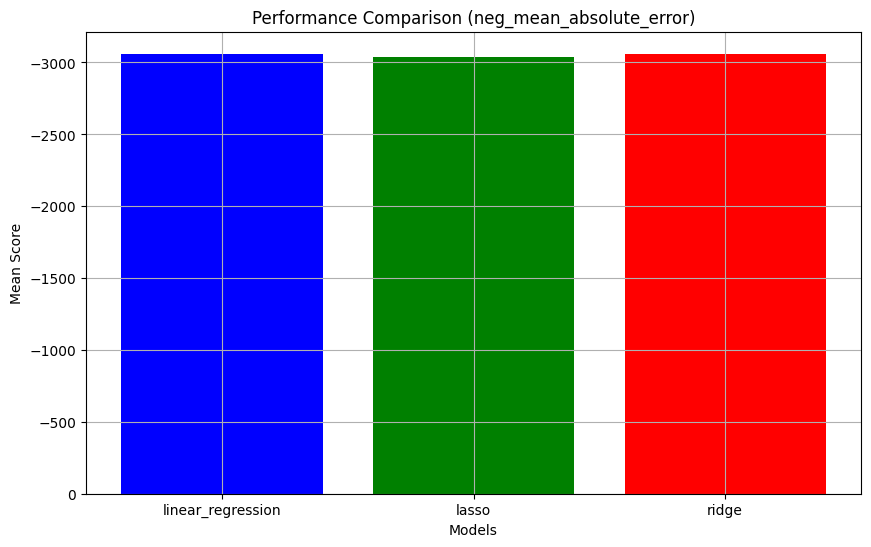

In [127]:
performance_comparison(results_linear)

Saved Learning Curve (linear_regression, neg_mean_absolute_error).png
                                                         Model  \
0  Learning Curve (linear_regression, neg_mean_absolute_error)   

   Train Score Variance  Test Score Variance  Train Score Std dev  \
0           2191.703709          6591.385425            46.815635   

   Test Score Std dev     Ratio  
0           81.187348  3.007425  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_46232\2961725597.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (lasso, neg_mean_absolute_error).png
                                                         Model  \
0  Learning Curve (linear_regression, neg_mean_absolute_error)   
1              Learning Curve (lasso, neg_mean_absolute_error)   

   Train Score Variance  Test Score Variance  Train Score Std dev  \
0           2191.703709          6591.385425            46.815635   
1           3750.546223          8565.954628            61.241703   

   Test Score Std dev     Ratio  
0           81.187348  3.007425  
1           92.552443  2.283922  
Saved Learning Curve (ridge, neg_mean_absolute_error).png
                                                         Model  \
0  Learning Curve (linear_regression, neg_mean_absolute_error)   
1              Learning Curve (lasso, neg_mean_absolute_error)   
2              Learning Curve (ridge, neg_mean_absolute_error)   

   Train Score Variance  Test Score Variance  Train Score Std dev  \
0           2191.703709          6591.385

,Model,Train Score Variance,Test Score Variance,Train Score Std dev,Test Score Std dev,Ratio
0,"Learning Curve (linear_regression, neg_mean_absolute_error)",2191.703709,6591.385425,46.815635,81.187348,3.007425
1,"Learning Curve (lasso, neg_mean_absolute_error)",3750.546223,8565.954628,61.241703,92.552443,2.283922
2,"Learning Curve (ridge, neg_mean_absolute_error)",2085.628383,7564.489001,45.668681,86.974071,3.626959


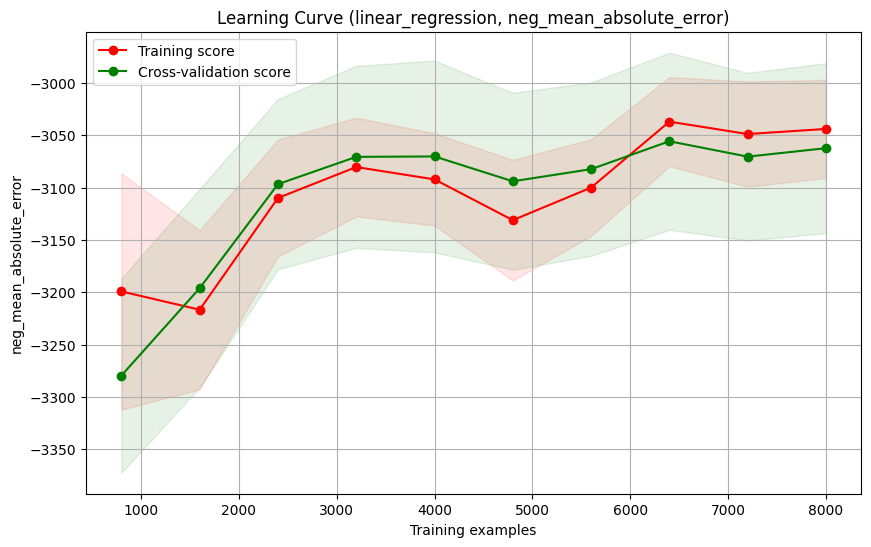

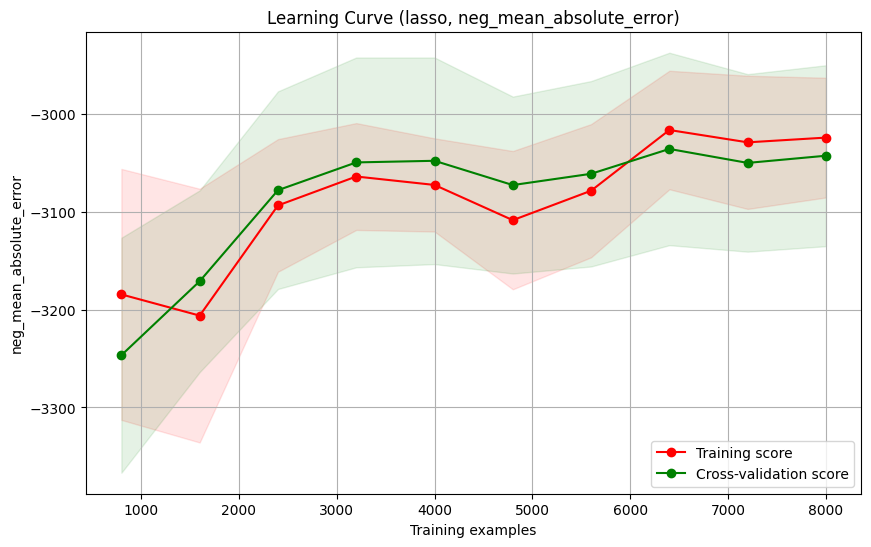

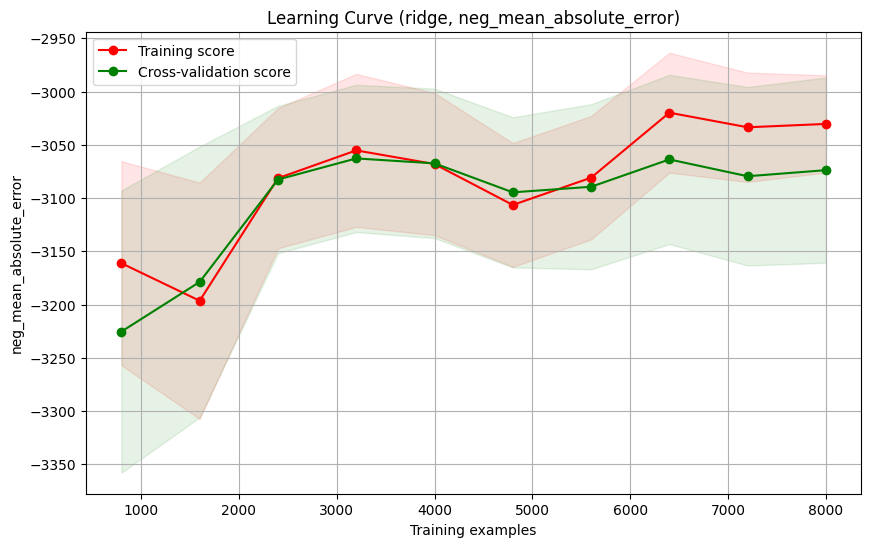

In [128]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
show_learning_curves(results_linear, X, y, cv)

# Riassunto documentazione

In questo notebook abbiamo eseguito un'analisi dei dati su un dataset di auto usate, con l'obiettivo di prevedere il prezzo di vendita di un'auto in base alle sue caratteristiche. Abbiamo eseguito un'analisi esplorativa dei dati, effettuato il preprocessing dei dati, addestrato modelli di apprendimento supervisionato e non supervisionato, e ridotto la dimensionalità dei dati utilizzando la PCA.

Abbiamo confrontato le prestazioni dei modelli addestrati utilizzando diverse metriche di scoring e visualizzato le curve di apprendimento per valutare il trade-off tra bias e varianza. Infine, abbiamo esaminato l'impatto della riduzione della dimensionalità sui modelli di apprendimento supervisionato.

I risultati ottenuti mostrano che i modelli di Random Forest e Gradient Boosted Trees hanno prestazioni migliori rispetto al Decision Tree, con il Gradient Boosted Trees che fornisce i risultati migliori in termini di metriche di scoring. Inoltre, la riduzione della dimensionalità tramite PCA ha portato a una riduzione delle prestazioni dei modelli di apprendimento supervisionato, con un aumento della varianza e una diminuzione della capacità predittiva.

In futuro, potremmo esplorare ulteriori tecniche di preprocessing dei dati, addestrare modelli più complessi e ottimizzare ulteriormente gli iperparametri per migliorare le prestazioni dei modelli. Inoltre, potremmo esplorare altre tecniche di riduzione della dimensionalità e valutare il loro impatto sui modelli di apprendimento supervisionato.

# Uso della base di conoscenza nel nostro progetto

Fatto macchina
Fatto marca che collega title e marca

Regola per la classe di economicità

Ibrida a classe euro



# Da albero a prolog

In [130]:
dtree = results["neg_mean_absolute_error"]["decision_tree"]["model"]

In [136]:
from sklearn.tree import _tree


def extract_tree_structure(tree, feature_names):
    tree_ = tree.tree_
    feature_names = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if ({name} <= {threshold:.2f}) {{")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}}} else {{")
            recurse(tree_.children_right[node], depth + 1)
            print(f"{indent}}}")
        else:
            print(f"{indent}return {tree_.value[node]}")

    recurse(0, 0)


# Extract tree structure
def tree_to_prolog(regressor, node_id=0, parent_id=None):
    base_code = """
predict(Features, Prediction) :-
    traverse_tree(0, Features, Prediction).

% Passo base
traverse_tree(NodeID, _, Prediction) :-
    leaf(NodeID, Prediction).

% Passo ricorsivo
traverse_tree(NodeID, Features, Prediction) :-
    node(NodeID, FeatureIndex, Threshold, LeftChild, RightChild, _),
    nth0(FeatureIndex, Features, FeatureValue),
    (FeatureValue =< Threshold ->
        traverse_tree(LeftChild, Features, Prediction)
    ;
        traverse_tree(RightChild, Features, Prediction)
    ).

"""

    result = ""
    # Check if it's a leaf node
    if regressor.tree_.children_left[node_id] == -1:
        # Leaf node
        value = regressor.tree_.value[node_id][0, 0]  # Assuming single target value
        result += f"leaf({node_id}, {value}).\n"
    else:
        # Decision node
        feature = regressor.tree_.feature[node_id]
        threshold = regressor.tree_.threshold[node_id]
        left_child = regressor.tree_.children_left[node_id]
        right_child = regressor.tree_.children_right[node_id]
        result += f"node({node_id}, {feature}, {threshold}, {left_child}, {right_child}, _).\n"
        # Recursively add left and right children
        result += tree_to_prolog(regressor, left_child, node_id)
        result += tree_to_prolog(regressor, right_child, node_id)
    result = "\n".join(sorted(result.split("\n")))
    if parent_id is None:
        return base_code + result
    return result


pl = tree_to_prolog(dtree)
with open("decision_tree.pl", "w", encoding="utf-8") as f:
    f.write(pl)


In [1]:
print("a")
from pyswip import Prolog
print("a")
prolog = Prolog()
print("a")
prolog.consult("decision_tree.pl")
print("b")
features = list(X.iloc[0].values.astype(float))

print(features)


dtree_pred = dtree.predict([X.iloc[0].values])
print(f"Decision tree prediction: {dtree_pred}")

prolog_pred = prolog.query(f"predict({features}, Prediction)")
print(f"Prolog prediction: {list(prolog_pred)}")

a
a
a
b


NameError: name 'X' is not defined